In [2]:
from endless_line.data_utils.dataloader import DataLoader

LOAD AND CLEAN DATSETS

In [3]:
data = DataLoader(data_dir_path="data", load_all_files=True)
DataLoader.clean_data(data)
DataLoader.data_preprocessing_attendance_pred(data)



/Users/kiran/Hackathon-ElevenStrategy/endless_line/data_utils/dataloader.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.parade_night_show_attendance["Num_parade"] = 3 - self.parade_night_show_attendance[["NIGHT_SHOW",	"PARADE_1",	"PARADE_2"]].isna().sum(axis=1)


OUTPUT OF CLEAN DATA

In [4]:
print(data.attendance.dtypes)

USAGE_DATE    datetime64[ns]
attendance             int64
dtype: object


In [4]:
import pandas as pd

In [6]:
pip install skitlearn --quite


Usage:   
  /Users/kiran/.pyenv/versions/3.10.7/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /Users/kiran/.pyenv/versions/3.10.7/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /Users/kiran/.pyenv/versions/3.10.7/bin/python -m pip install [options] [-e] <vcs project url> ...
  /Users/kiran/.pyenv/versions/3.10.7/bin/python -m pip install [options] [-e] <local project path> ...
  /Users/kiran/.pyenv/versions/3.10.7/bin/python -m pip install [options] <archive url/path> ...

no such option: --quite
Note: you may need to restart the kernel to use updated packages.


In [6]:
from prophet import Prophet

In [5]:
df = data.attendance[['USAGE_DATE','attendance']]

In [7]:
df.rename(columns={'USAGE_DATE': 'ds', 'attendance': 'y'}, inplace=True)

In [8]:
df_train = df[df['ds'] < '2022-03-01']
df_test = df[df['ds'] >= '2022-03-01']

In [9]:
model = Prophet()
model.fit(df_train)
future = model.make_future_dataframe(periods=len(df_test), freq='D')
forecast = model.predict(future)

18:32:35 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
import matplotlib.pyplot as plt

In [ ]:
# Step 6: Visualize Actual vs Predictions
# Merge actual and forecast data for comparison
df_forecast = forecast[['ds', 'yhat']].copy()
df_forecast = df_forecast.set_index('ds')
df_actual = df.set_index('ds')

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(df_actual.index, df_actual['y'], label='Actual Attendance', color='blue', linewidth=2, marker='o')
plt.plot(df_forecast.index, df_forecast['yhat'], label='Predicted Attendance', color='red', linestyle='--', linewidth=2)

# Highlight test data
plt.axvspan(df_test['ds'].min(), df_test['ds'].max(), color='yellow', alpha=0.2, label='Test Period')

# Chart Customization
plt.title("Actual vs Predicted Attendance", fontsize=18, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Attendance", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

# Show Plot
plt.show()

In [10]:
from datetime import date
import holidays

# Create France holidays for the relevant years
fr_holidays = holidays.France(years=range(2018, 2023))

# Convert to DataFrame
holidays_df = pd.DataFrame(
    {'ds': list(fr_holidays.keys()), 'holiday': list(fr_holidays.values())}
)

In [ ]:
from prophet import Prophet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error


# Split Train/Test
df_train = df[df['ds'] < '2022-04-01']
df_test = df[df['ds'] >= '2022-04-01']

# Define Model
model = Prophet(
    #growth='flat',
    changepoint_prior_scale=0.001,
    seasonality_mode='multiplicative',
    interval_width=0.95,
    holidays=holidays_df
)
model.add_seasonality(name='yearly', period=365, fourier_order=5)

# Train Model
model.fit(df_train)

# Predict
future = model.make_future_dataframe(periods=len(df_test), freq='D')
forecast = model.predict(future)

# Revert predictions and actual data back from log scale
df_test['y_actual'] = np.expm1(df_test['y'])
forecast['yhat_exp'] = np.expm1(forecast['yhat'])

# Filter only test data predictions for MSE calculation
forecast_test = forecast[forecast['ds'] >= '2022-04-01']

# Calculate MSE
mse = mean_squared_error(df_test['y_actual'], forecast_test['yhat_exp'])
print(f"Mean Squared Error (MSE): {mse}")

# Plot Actual vs Predicted
plt.figure(figsize=(14, 8))
plt.plot(df['ds'], df['y'], label='Actual Attendance', color='blue', marker='')
plt.plot(forecast['ds'], np.expm1(forecast['yhat']), label='Predicted Attendance', color='red', linestyle='--')

plt.axvspan('2022-06-01', forecast['ds'].max(), color='yellow', alpha=0.2, label='Test Period')
plt.title('Actual vs Predicted Attendance', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Attendance', fontsize=14)
plt.legend()
plt.grid()
plt.show()

##Mean Squared Error (MSE): 0.00010011577589772141 

18:36:45 - cmdstanpy - INFO - Chain [1] start processing
18:36:45 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/rk/8c_5m9t103bc7prmfk4b39c00000gn/T/ipykernel_92285/1337132889.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_actual'] = df_test['y']


0 0
0 0
Mean Squared Error (MSE): 192470457.7829246


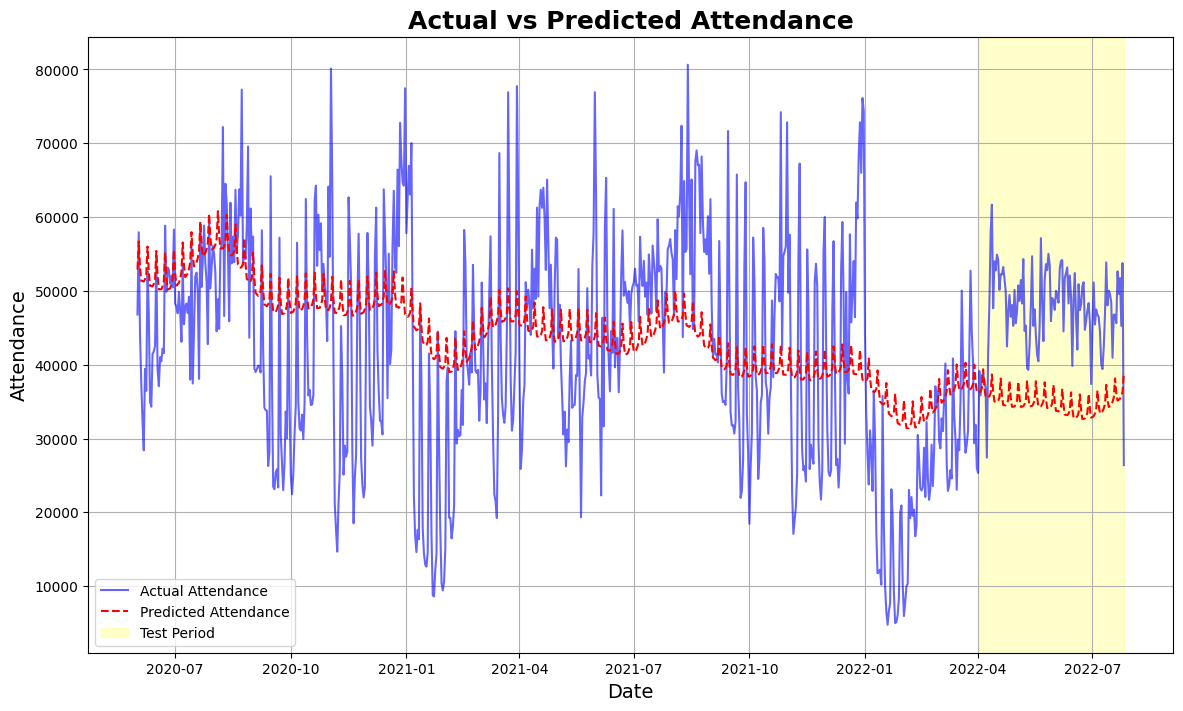

In [13]:
from prophet import Prophet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Split Train/Test
df_train = df[df['ds'] < '2022-04-01']
df_test = df[df['ds'] >= '2022-04-01']

# Define Model
model = Prophet(
    changepoint_prior_scale=0.001,  # Penalizes large trend changes
    seasonality_mode='multiplicative',
    interval_width=0.95,
    holidays=holidays_df  # Add your holiday dataframe if applicable
)
model.add_seasonality(name='yearly', period=365, fourier_order=5)

# Train Model
model.fit(df_train)

# Predict
future = model.make_future_dataframe(periods=len(df_test), freq='D')
forecast = model.predict(future)

# Remove anomalies in the test data and forecast
df_test['y_actual'] = df_test['y']
forecast['yhat_raw'] = forecast['yhat']

# Filter only test data predictions
forecast_test = forecast[forecast['ds'] >= '2022-04-01']

# Debugging: Check for NaN or Inf values
print(df_test['y_actual'].isnull().sum(), forecast_test['yhat_raw'].isnull().sum())
print(np.isinf(df_test['y_actual']).sum(), np.isinf(forecast_test['yhat_raw']).sum())

# Handle missing values
df_test = df_test[df_test['y_actual'].notnull()]
forecast_test = forecast_test[forecast_test['yhat_raw'].notnull()]
df_test = df_test[~np.isinf(df_test['y_actual'])]
forecast_test = forecast_test[~np.isinf(forecast_test['yhat_raw'])]

# Ensure alignment between test data and forecast
forecast_test = forecast_test[forecast_test['ds'].isin(df_test['ds'])]
df_test = df_test[df_test['ds'].isin(forecast_test['ds'])]

# Calculate MSE
mse = mean_squared_error(df_test['y_actual'], forecast_test['yhat_raw'])
print(f"Mean Squared Error (MSE): {mse}")

# Plot Actual vs Predicted
plt.figure(figsize=(14, 8))
plt.plot(df['ds'], df['y'], label='Actual Attendance', color='blue', marker='', alpha=0.6)
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Attendance', color='red', linestyle='--')

plt.axvspan('2022-04-01', forecast['ds'].max(), color='yellow', alpha=0.2, label='Test Period')
plt.title('Actual vs Predicted Attendance', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Attendance', fontsize=14)
plt.legend()
plt.grid()
plt.show()


EXPLORING THE PREPROCESSED DATA
---- for presentation purposes

Checking why attendance went missing

In [18]:
data = DataLoader(data_dir_path="data", load_all_files=True)

In [19]:
print(data.attendance['USAGE_DATE'].head())

0    2018-06-01
1    2018-06-01
2    2018-06-02
3    2018-06-02
4    2018-06-03
Name: USAGE_DATE, dtype: object


In [2]:
data = DataLoader(data_dir_path="data", load_all_files=True)
DataLoader.clean_data(data)
DataLoader.data_preprocessing(data)

/Users/kiran/Hackathon-ElevenStrategy/endless_line/data_utils/dataloader.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.parade_night_show_attendance["Num_parade"] = 3 - self.parade_night_show_attendance[["NIGHT_SHOW",	"PARADE_1",	"PARADE_2"]].isna().sum(axis=1)


In [3]:
DataLoader.data_preprocessing(data)

In [8]:
data.waiting_times

,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,ENTITY_DESCRIPTION_SHORT,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,OPEN_TIME,UP_TIME,DOWNTIME,NB_MAX_UNIT
0,2020-01-01,2020-01-01 21:00:00,21,2020-01-01 21:15:00,Roller Coaster,0,2.0,0.0,0.000,0.00,0,0,0,2.0
1,2020-01-01,2020-01-01 19:30:00,19,2020-01-01 19:45:00,Bumper Cars,5,18.0,148.0,254.749,254.75,15,15,0,18.0
2,2020-01-01,2020-01-01 22:30:00,22,2020-01-01 22:45:00,Rapids Ride,0,1.0,0.0,0.000,0.00,0,0,0,2.0
3,2020-01-01,2020-01-01 12:45:00,12,2020-01-01 13:00:00,Crazy Dance,5,1.0,46.0,250.001,250.00,15,15,0,1.0
4,2020-01-01,2020-01-01 17:00:00,17,2020-01-01 17:15:00,Skyway,5,15.0,92.0,211.500,198.25,15,15,0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3509319,2022-08-18,2022-08-18 18:45:00,18,2022-08-18 19:00:00,Himalaya Ride,0,0.0,0.0,0.000,0.00,0,0,0,1.0
3509320,2022-08-18,2022-08-18 10:15:00,10,2022-08-18 10:30:00,Crazy Dance,0,0.0,0.0,0.000,0.00,0,0,0,1.0
3509321,2022-08-18,2022-08-18 09:15:00,9,2022-08-18 09:30:00,Crazy Dance,0,0.0,0.0,0.000,0.00,0,0,0,1.0
3509322,2022-08-18,2022-08-18 20:30:00,20,2022-08-18 20:45:00,Giga Coaster,0,0.0,0.0,0.000,0.00,0,0,0,24.0


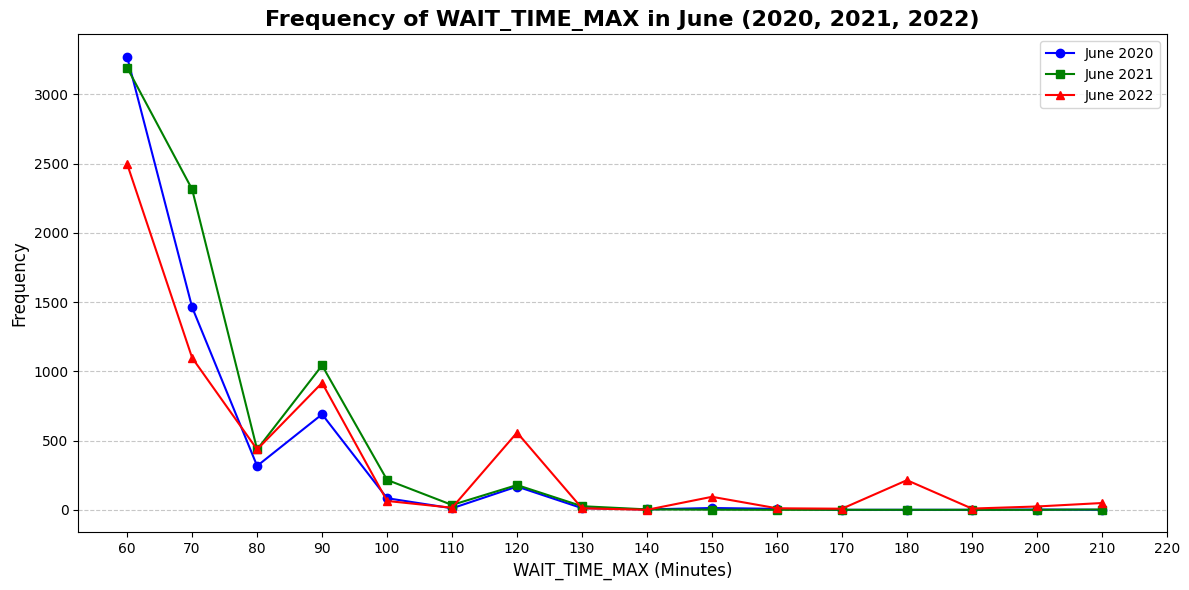

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame
df = pd.DataFrame(data.waiting_times)
attractions = data.link_attraction_park['ATTRACTION'].tolist()
df = df[df['ENTITY_DESCRIPTION_SHORT'].isin(attractions + ['PortAventura World'])]
# Convert WORK_DATE to datetime
df['WORK_DATE'] = pd.to_datetime(df['WORK_DATE'])
df = df[df['WAIT_TIME_MAX'] >= 60]

# Filter data for June 2020, June 2021, and June 2022
df_june_2020 = df[(df['WORK_DATE'].dt.year == 2020) & (df['WORK_DATE'].dt.month.isin([6,7]))]
df_june_2021 = df[(df['WORK_DATE'].dt.year == 2021) & (df['WORK_DATE'].dt.month.isin([6,7]))]
df_june_2022 = df[(df['WORK_DATE'].dt.year == 2022) & (df['WORK_DATE'].dt.month.isin([6,7]))]

# Calculate frequencies (histogram bins) for WAIT_TIME_MAX
bins = range(60, 221, 10)  # Create bins for 0 to 60 minutes with 5-minute intervals
freq_2020, _ = np.histogram(df_june_2020['WAIT_TIME_MAX'], bins=bins)
freq_2021, _ = np.histogram(df_june_2021['WAIT_TIME_MAX'], bins=bins)
freq_2022, _ = np.histogram(df_june_2022['WAIT_TIME_MAX'], bins=bins)

# Plot the line graphs
plt.figure(figsize=(12, 6))
plt.plot(bins[:-1], freq_2020, label="June 2020", marker='o', color='blue')
plt.plot(bins[:-1], freq_2021, label="June 2021", marker='s', color='green')
plt.plot(bins[:-1], freq_2022, label="June 2022", marker='^', color='red')

# Add labels, title, and legend
plt.title('Frequency of WAIT_TIME_MAX in June (2020, 2021, 2022)', fontsize=16, fontweight='bold')
plt.xlabel('WAIT_TIME_MAX (Minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(bins, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
df= data.attendance
# Filter data for June 2020, June 2021, and June 2022
df_june_2020 = df[(df['USAGE_DATE'].dt.year == 2020) & (df['USAGE_DATE'].dt.month.isin([6,7]))]
df_june_2021 = df[(df['USAGE_DATE'].dt.year == 2021) & (df['USAGE_DATE'].dt.month.isin([6,7]))]
df_june_2022 = df[(df['USAGE_DATE'].dt.year == 2022) & (df['USAGE_DATE'].dt.month.isin([6,7]))]

In [9]:
print(df_june_2022)

         WORK_DATE            DEB_TIME  DEB_TIME_HOUR            FIN_TIME  \
3337927 2022-06-01 2022-06-01 13:00:00             13 2022-06-01 13:15:00   
3337928 2022-06-01 2022-06-01 12:45:00             12 2022-06-01 13:00:00   
3337948 2022-06-01 2022-06-01 18:45:00             18 2022-06-01 19:00:00   
3337953 2022-06-01 2022-06-01 14:00:00             14 2022-06-01 14:15:00   
3337954 2022-06-01 2022-06-01 19:15:00             19 2022-06-01 19:30:00   
...            ...                 ...            ...                 ...   
3402452 2022-06-30 2022-06-30 12:45:00             12 2022-06-30 13:00:00   
3402469 2022-06-30 2022-06-30 15:00:00             15 2022-06-30 15:15:00   
3402480 2022-06-30 2022-06-30 16:30:00             16 2022-06-30 16:45:00   
3402498 2022-06-30 2022-06-30 15:15:00             15 2022-06-30 15:30:00   
3402518 2022-06-30 2022-06-30 15:15:00             15 2022-06-30 15:30:00   

        ENTITY_DESCRIPTION_SHORT  WAIT_TIME_MAX  NB_UNITS  GUEST_CARRIED  \

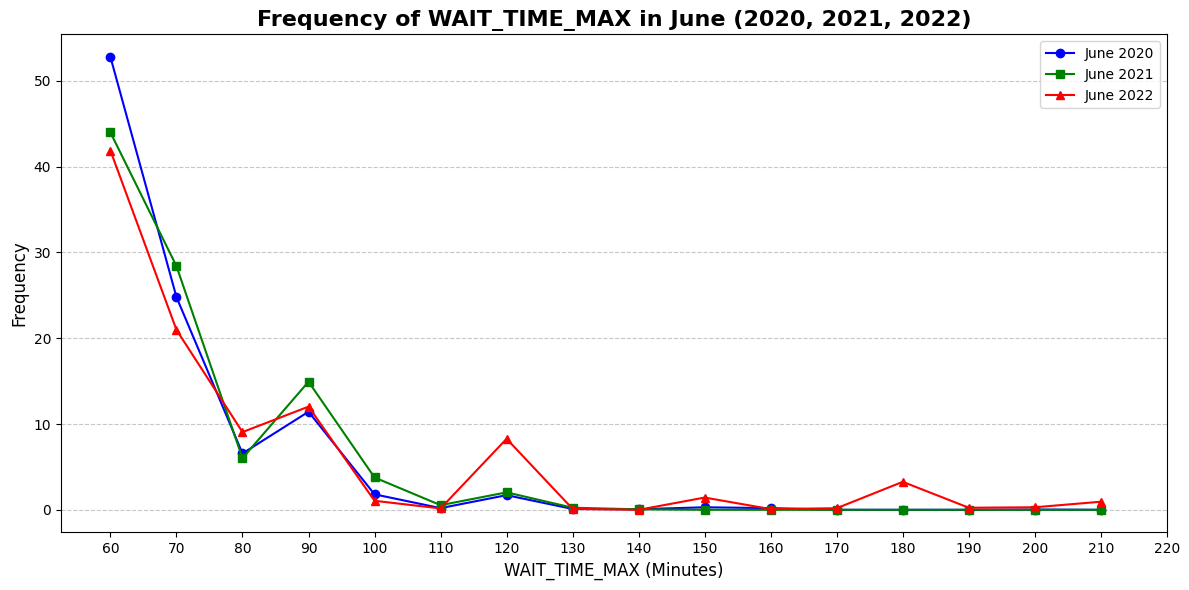

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame
df = pd.DataFrame(data.waiting_times)
attractions = data.link_attraction_park['ATTRACTION'].tolist()
df = df[df['ENTITY_DESCRIPTION_SHORT'].isin(attractions + ['PortAventura World'])]
# Convert WORK_DATE to datetime
df['WORK_DATE'] = pd.to_datetime(df['WORK_DATE'])
df = df[df['WAIT_TIME_MAX'] >= 60]

# Filter data for June 2020, June 2021, and June 2022
df_june_2020 = df[(df['WORK_DATE'].dt.year == 2020) & (df['WORK_DATE'].dt.month.isin([6]))]
df_june_2021 = df[(df['WORK_DATE'].dt.year == 2021) & (df['WORK_DATE'].dt.month.isin([6]))]
df_june_2022 = df[(df['WORK_DATE'].dt.year == 2022) & (df['WORK_DATE'].dt.month.isin([6]))]

# Calculate frequencies (histogram bins) for WAIT_TIME_MAX
bins = range(60, 221, 10)  # Create bins for 0 to 60 minutes with 5-minute intervals
freq_2020, _ = np.histogram(df_june_2020['WAIT_TIME_MAX'], bins=bins)
freq_2021, _ = np.histogram(df_june_2021['WAIT_TIME_MAX'], bins=bins)
freq_2022, _ = np.histogram(df_june_2022['WAIT_TIME_MAX'], bins=bins)
freq_2020 = (freq_2020 / freq_2020.sum()) * 100 if freq_2020.sum() > 0 else freq_2020
freq_2021 = (freq_2021 / freq_2021.sum()) * 100 if freq_2021.sum() > 0 else freq_2021
freq_2022 = (freq_2022 / freq_2022.sum()) * 100 if freq_2022.sum() > 0 else freq_2022

# Plot the line graphs
plt.figure(figsize=(12, 6))
plt.plot(bins[:-1], freq_2020, label="June 2020", marker='o', color='blue')
plt.plot(bins[:-1], freq_2021, label="June 2021", marker='s', color='green')
plt.plot(bins[:-1], freq_2022, label="June 2022", marker='^', color='red')

# Add labels, title, and legend
plt.title('Frequency of WAIT_TIME_MAX in June (2020, 2021, 2022)', fontsize=16, fontweight='bold')
plt.xlabel('WAIT_TIME_MAX (Minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(bins, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

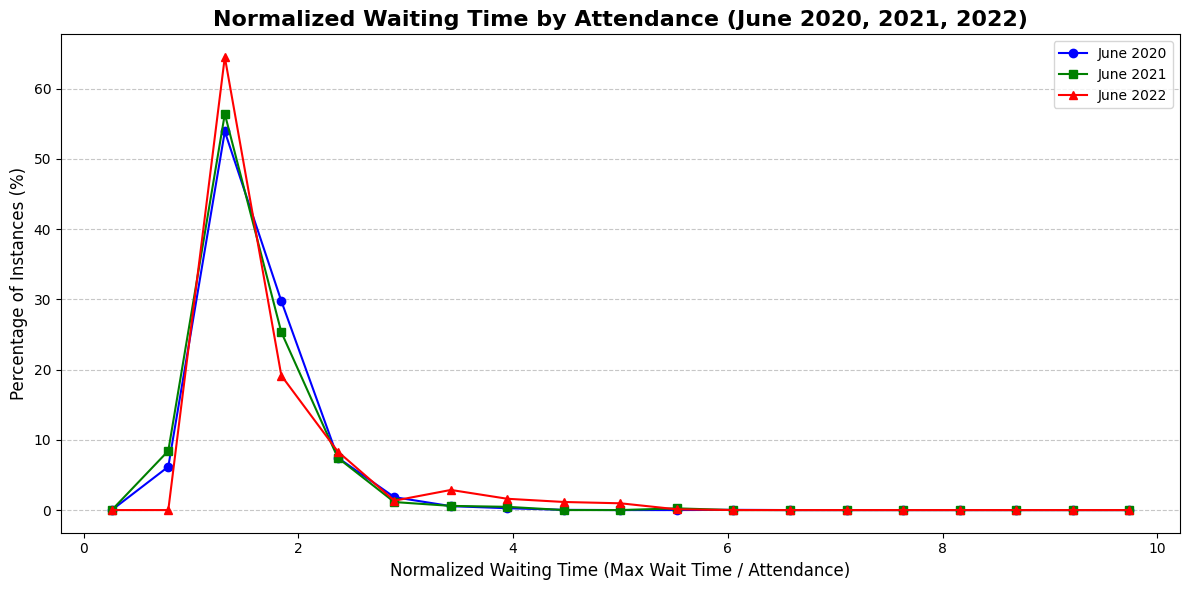

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create DataFrames
df_waiting = pd.DataFrame(data.waiting_times)
df_attendance = pd.DataFrame(data.attendance)

# Convert WORK_DATE to datetime
df_waiting['WORK_DATE'] = pd.to_datetime(df_waiting['WORK_DATE'])
df_attendance['WORK_DATE'] = pd.to_datetime(df_attendance['USAGE_DATE'])
df_waiting['WAIT_TIME_MAX'] = df_waiting['WAIT_TIME_MAX'].astype('int64')
df_attendance['attendance'] = df_attendance['attendance'].astype('int64')
# Merge the two datasets on WORK_DATE
df_merged = pd.merge(df_waiting, df_attendance, on="WORK_DATE", how="left")
df_merged = df_merged[df_merged['WAIT_TIME_MAX'] >= 60]
# Normalize waiting time by attendance
df_merged['NORMALIZED_WAIT_TIME'] = df_merged['WAIT_TIME_MAX'] / (df_merged['attendance']/1000)
# Filter data for June 2020, June 2021, and June 2022
df_june_2020 = df_merged[(df_merged['WORK_DATE'].dt.year == 2020) & (df_merged['WORK_DATE'].dt.month.isin([6]))]
df_june_2021 = df_merged[(df_merged['WORK_DATE'].dt.year == 2021) & (df_merged['WORK_DATE'].dt.month.isin([6]))]
df_june_2022 = df_merged[(df_merged['WORK_DATE'].dt.year == 2022) & (df_merged['WORK_DATE'].dt.month.isin([6]))]

# Define bins
bins = np.linspace(0, 10, 20) # Adjust bins for normalized waiting time

# Calculate normalized frequencies for each year
freq_2020, _ = np.histogram(df_june_2020['NORMALIZED_WAIT_TIME'], bins=bins)
freq_2021, _ = np.histogram(df_june_2021['NORMALIZED_WAIT_TIME'], bins=bins)
freq_2022, _ = np.histogram(df_june_2022['NORMALIZED_WAIT_TIME'], bins=bins)

# Normalize frequencies (convert to percentages)
freq_2020 = (freq_2020 / freq_2020.sum()) * 100 if freq_2020.sum() > 0 else freq_2020
freq_2021 = (freq_2021 / freq_2021.sum()) * 100 if freq_2021.sum() > 0 else freq_2021
freq_2022 = (freq_2022 / freq_2022.sum()) * 100 if freq_2022.sum() > 0 else freq_2022

# Plot the normalized line graphs
plt.figure(figsize=(12, 6))
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, freq_2020, label="June 2020", marker='o', color='blue')
plt.plot(bin_centers, freq_2021, label="June 2021", marker='s', color='green')
plt.plot(bin_centers, freq_2022, label="June 2022", marker='^', color='red')

# Add labels, title, and legend
plt.title('Normalized Waiting Time by Attendance (June 2020, 2021, 2022)', fontsize=16, fontweight='bold')
plt.xlabel('Normalized Waiting Time (Max Wait Time / Attendance)', fontsize=12)
plt.ylabel('Percentage of Instances (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


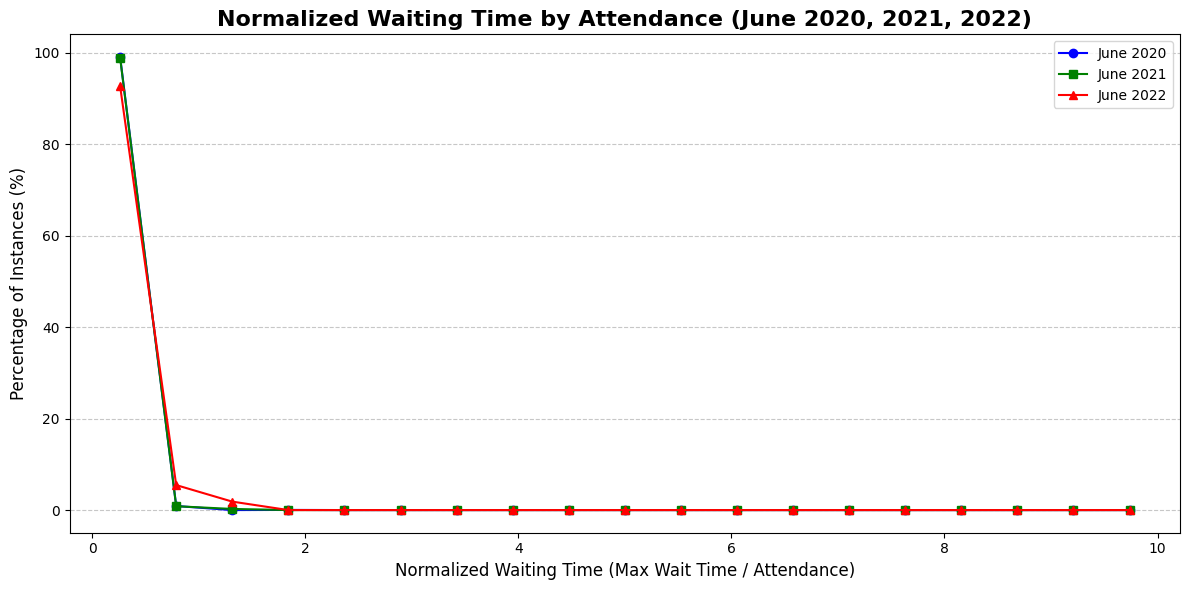

In [50]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Scale WAIT_TIME_MAX and ATTENDANCE to range [0, 1]
df_merged['SCALED_WAIT_TIME'] = scaler.fit_transform(df_merged[['WAIT_TIME_MAX']])
df_merged['SCALED_ATTENDANCE'] = scaler.fit_transform(df_merged[['attendance']])
df_merged = df_merged[df_merged['WAIT_TIME_MAX'] >= 60]
# Calculate Normalized Waiting Time
df_merged['NORMALIZED_WAIT_TIME'] = df_merged['SCALED_WAIT_TIME'] / df_merged['SCALED_ATTENDANCE']
# Filter data for June 2020, June 2021, and June 2022
df_june_2020 = df_merged[(df_merged['WORK_DATE'].dt.year == 2020) & (df_merged['WORK_DATE'].dt.month.isin([6]))]
df_june_2021 = df_merged[(df_merged['WORK_DATE'].dt.year == 2021) & (df_merged['WORK_DATE'].dt.month.isin([6]))]
df_june_2022 = df_merged[(df_merged['WORK_DATE'].dt.year == 2022) & (df_merged['WORK_DATE'].dt.month.isin([6]))]

# Define bins
bins = np.linspace(0, 10, 20) # Adjust bins for normalized waiting time

# Calculate normalized frequencies for each year
freq_2020, _ = np.histogram(df_june_2020['NORMALIZED_WAIT_TIME'], bins=bins)
freq_2021, _ = np.histogram(df_june_2021['NORMALIZED_WAIT_TIME'], bins=bins)
freq_2022, _ = np.histogram(df_june_2022['NORMALIZED_WAIT_TIME'], bins=bins)

# Normalize frequencies (convert to percentages)
freq_2020 = (freq_2020 / freq_2020.sum()) * 100 if freq_2020.sum() > 0 else freq_2020
freq_2021 = (freq_2021 / freq_2021.sum()) * 100 if freq_2021.sum() > 0 else freq_2021
freq_2022 = (freq_2022 / freq_2022.sum()) * 100 if freq_2022.sum() > 0 else freq_2022

# Plot the normalized line graphs
plt.figure(figsize=(12, 6))
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, freq_2020, label="June 2020", marker='o', color='blue')
plt.plot(bin_centers, freq_2021, label="June 2021", marker='s', color='green')
plt.plot(bin_centers, freq_2022, label="June 2022", marker='^', color='red')

# Add labels, title, and legend
plt.title('Normalized Waiting Time by Attendance (June 2020, 2021, 2022)', fontsize=16, fontweight='bold')
plt.xlabel('Normalized Waiting Time (Max Wait Time / Attendance)', fontsize=12)
plt.ylabel('Percentage of Instances (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


In [36]:
data.attendance

,USAGE_DATE,attendance
0,2020-06-01,46804
2,2020-06-02,57940
4,2020-06-03,44365
6,2020-06-04,37617
8,2020-06-05,32438
...,...,...
2357,2022-07-22,49586
2359,2022-07-23,51748
2361,2022-07-24,45261
2363,2022-07-25,53764


In [51]:
data.waiting_times



,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,ENTITY_DESCRIPTION_SHORT,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,OPEN_TIME,UP_TIME,DOWNTIME,NB_MAX_UNIT
0,2020-01-01,2020-01-01 21:00:00,21,2020-01-01 21:15:00,Roller Coaster,0,2.0,0.0,0.000,0.00,0,0,0,2.0
1,2020-01-01,2020-01-01 19:30:00,19,2020-01-01 19:45:00,Bumper Cars,5,18.0,148.0,254.749,254.75,15,15,0,18.0
2,2020-01-01,2020-01-01 22:30:00,22,2020-01-01 22:45:00,Rapids Ride,0,1.0,0.0,0.000,0.00,0,0,0,2.0
3,2020-01-01,2020-01-01 12:45:00,12,2020-01-01 13:00:00,Crazy Dance,5,1.0,46.0,250.001,250.00,15,15,0,1.0
5,2020-01-01,2020-01-01 18:15:00,18,2020-01-01 18:30:00,Free Fall,50,3.0,0.0,0.000,0.00,0,0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3509319,2022-08-18,2022-08-18 18:45:00,18,2022-08-18 19:00:00,Himalaya Ride,0,0.0,0.0,0.000,0.00,0,0,0,1.0
3509320,2022-08-18,2022-08-18 10:15:00,10,2022-08-18 10:30:00,Crazy Dance,0,0.0,0.0,0.000,0.00,0,0,0,1.0
3509321,2022-08-18,2022-08-18 09:15:00,9,2022-08-18 09:30:00,Crazy Dance,0,0.0,0.0,0.000,0.00,0,0,0,1.0
3509322,2022-08-18,2022-08-18 20:30:00,20,2022-08-18 20:45:00,Giga Coaster,0,0.0,0.0,0.000,0.00,0,0,0,24.0


In [ ]:
df = pd.DataFrame(data.waiting_times)
attractions = data.link_attraction_park['ATTRACTION'].tolist()
df = df[df['ENTITY_DESCRIPTION_SHORT'].isin(attractions + ['PortAventura World'])]
df_attendance = pd.DataFrame(data.attendance)

# Convert WORK_DATE and DEB_TIME to datetime objects
df['WORK_DATE'] = pd.to_datetime(df['WORK_DATE'])
df['DEB_TIME'] = pd.to_datetime(df['DEB_TIME'])

df_attendance['WORK_DATE'] = pd.to_datetime(df_attendance['USAGE_DATE'])
df['WAIT_TIME_MAX'] = df['WAIT_TIME_MAX'].astype('int64')
df_attendance['attendance'] = df_attendance['attendance'].astype('int64')
# No entity filter this time, we want all entities
df_all_entities = df.copy()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Merge attendance data with waiting times
df_all_entities = df_all_entities.merge(df_attendance[['WORK_DATE', 'attendance']], on='WORK_DATE', how='left')

# Normalize attendance by dividing by 1000
df_all_entities['ATTENDANCE_NORMALIZED'] = df_all_entities['attendance'] / 1000

# Calculate normalized waiting time
df_all_entities['WAIT_TIME_NORMALIZED'] = df_all_entities['WAIT_TIME_MAX'] / df_all_entities['ATTENDANCE_NORMALIZED']

# Add year and month columns for grouping
df_all_entities['YEAR'] = df_all_entities['WORK_DATE'].dt.year
df_all_entities['MONTH_DAY'] = df_all_entities['WORK_DATE'].dt.strftime('%m-%d')  # Month and day for x-axis

# Filter for years of interest (2020, 2021, 2022) and Jan-Jul
df_filtered_years = df_all_entities[
    (df_all_entities['YEAR'].isin([2021, 2022])) &
    (df_all_entities['WORK_DATE'].dt.month.isin([4,5,6]))  # January to July
]

# Group by Month-Day and Year, and calculate average normalized waiting time
avg_waiting_times = (
    df_filtered_years.groupby(['MONTH_DAY', 'YEAR'])['WAIT_TIME_NORMALIZED']
    .mean()
    .reset_index()
    .pivot(index='MONTH_DAY', columns='YEAR', values='WAIT_TIME_NORMALIZED')  # Pivot for easier plotting
)

# Sort by Month-Day for correct x-axis order
avg_waiting_times = avg_waiting_times.sort_index()

# Customize line colors and legends
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # You can change these to any color you like
legend_labels = ['2021', '2022']  # Customize your legend labels

# Plotting
plt.figure(figsize=(16, 8))
for idx, year in enumerate(avg_waiting_times.columns):
    plt.plot(avg_waiting_times.index, avg_waiting_times[year], label=legend_labels[idx], color=colors[idx], marker='o')  # Custom color and legend label

# Customize the plot
plt.title('Average Normalized Waiting Time (Jan to July, 2021-2022)', fontsize=16, fontweight='bold')
plt.xlabel('Month-Day', fontsize=14)
plt.ylabel('Average Normalized Waiting Time', fontsize=14)
plt.xticks(
    ticks=np.arange(0, len(avg_waiting_times.index), step=10),  # Show every ~10th day
    labels=avg_waiting_times.index[::10],
    rotation=45,
    ha='right'
)
plt.legend(title='Year', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# Display average waiting times for review
print("Average Normalized Waiting Times (Jan to July) by Day and Year:")
display(avg_waiting_times)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np

# Assuming df and df_attendance are already preprocessed
# Merge attendance data with the waiting time data on WORK_DATE
df_all_entities = df_all_entities.merge(df_attendance[['WORK_DATE', 'attendance']], on='WORK_DATE', how='left')

# Normalize attendance by dividing by 1000
df_all_entities['ATTENDANCE_NORMALIZED'] = df_all_entities['attendance'] / 1000

# Identify waiting times higher than 60 minutes
df_high_wait_times = df_all_entities[df_all_entities['WAIT_TIME_MAX'] > 60].copy()

# Group by Year-Month and ENTITY_DESCRIPTION_SHORT, and calculate normalized counts
monthly_entity_high_wait_counts = (
    df_high_wait_times.groupby([pd.Grouper(key='WORK_DATE', freq='M'), 'ENTITY_DESCRIPTION_SHORT'])
    .apply(lambda x: x['WAIT_TIME_MAX'].count() / x['ATTENDANCE_NORMALIZED'].sum())
    .reset_index(name='NORMALIZED_COUNT_HIGH_WAIT_TIMES')
)
monthly_entity_high_wait_counts.rename(columns={'WORK_DATE': 'MONTH_YEAR'}, inplace=True)  # Rename for clarity

# Format MONTH_YEAR column to "Month-Year" strings for x-axis labels
monthly_entity_high_wait_counts['MONTH_YEAR_STR'] = monthly_entity_high_wait_counts['MONTH_YEAR'].dt.strftime('%Y-%m')

# Sort by month-year and entity for consistent stacking order
monthly_entity_high_wait_counts = monthly_entity_high_wait_counts.sort_values(by=['MONTH_YEAR', 'ENTITY_DESCRIPTION_SHORT'])

# --- COLOR CYCLER ---
unique_entities = df['ENTITY_DESCRIPTION_SHORT'].unique()  # Get unique entities for color cycle
num_entities = len(unique_entities)

prop_cycle = cycler(color=plt.cm.tab20(np.linspace(0, 1, num_entities)))  # Use tab20 for more distinct colors
plt.rc('axes', prop_cycle=prop_cycle)  # Set color cycle for axes
# --- END COLOR CYCLER ---

# Create the plot - Stacked Bar chart for normalized counts per entity
plt.figure(figsize=(16, 9))  # Adjust figure size for stacked bar chart and legend
ax = plt.gca()  # Get current axes

# Get unique months for x-axis
unique_months = monthly_entity_high_wait_counts['MONTH_YEAR_STR'].unique()

# Initialize bottom position for stacking bars
bottom_positions = np.zeros(len(unique_months))

# Iterate through each entity and plot bars for each month, stacked
for i, entity_name in enumerate(unique_entities):
    entity_monthly_data = monthly_entity_high_wait_counts[
        monthly_entity_high_wait_counts['ENTITY_DESCRIPTION_SHORT'] == entity_name
    ]
    entity_counts = entity_monthly_data['NORMALIZED_COUNT_HIGH_WAIT_TIMES'].values
    entity_months = entity_monthly_data['MONTH_YEAR_STR'].values

    # Ensure months are in the same order as unique_months for stacking alignment
    counts_aligned = []
    for month_str in unique_months:
        if month_str in entity_months:
            counts_aligned.append(
                entity_monthly_data[entity_monthly_data['MONTH_YEAR_STR'] == month_str]['NORMALIZED_COUNT_HIGH_WAIT_TIMES'].values[0]
            )
        else:
            counts_aligned.append(0)  # If entity has no data for this month, count is 0

    ax.bar(unique_months, counts_aligned, label=entity_name, bottom=bottom_positions)  # Stacked bars
    bottom_positions += counts_aligned  # Update bottom for the next stack

# Customize the plot
ax.set_xlabel('Month-Year')  # X-axis label is now "Month-Year"
ax.set_ylabel('Normalized High Waiting Time Count (Divided by Attendance in 1000s)')
ax.set_title(f'Monthly Normalized Count of High WAIT_TIME_MAX (>60 min) per Attraction')
ax.grid(axis='y', linestyle='--')  # Grid lines only on y-axis for bar chart clarity
plt.xticks(rotation=45, ha='right')
plt.legend(title='Attraction', loc='upper left', bbox_to_anchor=(1.05, 1))  # Legend for attractions, outside plot
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Show the plot
plt.show()

print("\nMonthly Normalized Counts of High Waiting Times (WAIT_TIME_MAX > 60 min) per Attraction:")
display(monthly_entity_high_wait_counts[['MONTH_YEAR_STR', 'ENTITY_DESCRIPTION_SHORT', 'NORMALIZED_COUNT_HIGH_WAIT_TIMES']])  # Display relevant columns


In [1]:
from endless_line.data_utils.dataloader import DataLoader

BUILDING LSTM

In [20]:

data = DataLoader(data_dir_path="data", load_all_files=True)

data.clean_data()
data.data_preprocessing()
data.merge()


#print(data.merged.head())


/Users/kiran/Hackathon-ElevenStrategy/endless_line/data_utils/dataloader.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.parade_night_show_attendance["Num_parade"] = 3 - self.parade_night_show_attendance[["NIGHT_SHOW",	"PARADE_1",	"PARADE_2"]].isna().sum(axis=1)


In [21]:
pip install --upgrade --force-reinstall tensorflow

  Using cached tensorflow-2.18.0-cp310-cp310-macosx_12_0_arm64.whl (239.4 MB)
  Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached ml_dtypes-0.4.1-cp310-cp310-macosx_10_9_universal2.whl (397 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl (7.8 kB)
  Using cached packaging-24.2-py3-none-any.whl (65 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl (25.8 MB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached setuptools-75.8.0-py3-none-any.whl (1.2 MB)
  Using cached protobuf-5.29.3-cp38-abi3-macosx_10_9_universal2.whl (417 kB)
  Using cached keras-3.8.0-py3-none-any.whl (1.3 MB)
  Using cached tensorflow_io_gcs_filesystem-0.37.1-cp310-cp310-macosx_12_0_arm64.whl (3.5 MB)
  Using cached h5py-3.12.1-cp310-c

In [ ]:
pip show tensorflow

In [22]:
print(data.merged['ENTITY_DESCRIPTION_SHORT'].unique())

['Rapids Ride' 'Oz Theatre' 'Spiral Slide' 'Himalaya Ride' 'Free Fall'
 'Water Ride' 'Merry Go Round' 'Spinning Coaster' 'Go-Karts' 'Bumper Cars'
 'Kiddie Coaster' 'Bungee Jump' 'Roller Coaster' 'Flying Coaster'
 'Haunted House' 'Giga Coaster' 'Crazy Dance' 'Inverted Coaster'
 'Drop Tower' 'Circus Train' 'Zipline' 'Giant Wheel' 'Swing Ride'
 'Dizzy Dropper' 'Superman Ride']


In [7]:
print(data.merged.dtypes)

WORK_DATE                      datetime64[ns]
DEB_TIME                        datetime64[s]
DEB_TIME_HOUR                           int64
FIN_TIME                        datetime64[s]
ENTITY_DESCRIPTION_SHORT               object
WAIT_TIME_MAX                           int64
NB_UNITS                              float64
GUEST_CARRIED                         float64
CAPACITY                              float64
ADJUST_CAPACITY                       float64
OPEN_TIME                               int64
UP_TIME                                 int64
DOWNTIME                                int64
NB_MAX_UNIT                           float64
show_or_parade                          int64
Num_parade                            float64
Bumper Cars                           float64
Bungee Jump                           float64
Circus Train                          float64
Crazy Dance                           float64
Dizzy Dropper                         float64
Drop Tower                        

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf


# Identify columns to scale
columns_to_scale = [
    'NB_UNITS', 'GUEST_CARRIED', 'CAPACITY', 'ADJUST_CAPACITY','UP_TIME', 'DOWNTIME', 'NB_MAX_UNIT', 'Num_parade', 'temp', 
    'feels_like', 'pressure', 'wind_speed', 'clouds_all', 'attendance'
]

# Scale features to [0, 1] range
scaler = MinMaxScaler()
data.merged[columns_to_scale] = scaler.fit_transform(data.merged[columns_to_scale])

# Ensure DEB_TIME is a datetime column

data.merged['DEB_TIME'] = pd.to_datetime(data.merged['DEB_TIME'])

# Set DEB_TIME as the index and sort by it
data.merged = data.merged.sort_values('DEB_TIME').set_index('DEB_TIME')
# Drop rows with NaN values
data.merged = data.merged.dropna()


In [10]:
print(data.merged.columns)


Index(['WORK_DATE', 'DEB_TIME_HOUR', 'FIN_TIME', 'ENTITY_DESCRIPTION_SHORT',
       'WAIT_TIME_MAX', 'NB_UNITS', 'GUEST_CARRIED', 'CAPACITY',
       'ADJUST_CAPACITY', 'OPEN_TIME', 'UP_TIME', 'DOWNTIME', 'NB_MAX_UNIT',
       'show_or_parade', 'Num_parade', 'Bumper Cars', 'Bungee Jump',
       'Circus Train', 'Crazy Dance', 'Dizzy Dropper', 'Drop Tower',
       'Flying Coaster', 'Free Fall', 'Giant Wheel', 'Giga Coaster',
       'Go-Karts', 'Haunted House', 'Himalaya Ride', 'Inverted Coaster',
       'Kiddie Coaster', 'Merry Go Round', 'Oz Theatre', 'Rapids Ride',
       'Roller Coaster', 'Spinning Coaster', 'Spiral Slide', 'Superman Ride',
       'Swing Ride', 'Water Ride', 'Zipline', 'IS_OPEN', 'temp', 'feels_like',
       'pressure', 'wind_speed', 'clouds_all', 'weather_description_encoded',
       'weather_main_encoded', 'hour', 'day', 'month', 'day_of_week',
       'attendance'],
      dtype='object')


In [11]:
data.merged["WORK_DATE"] = data.merged["WORK_DATE"].astype(int)  # Convert datetime64 to integer timestamp
data.merged["FIN_TIME"] = data.merged["FIN_TIME"].astype(int)



In [13]:
data.merged = data.merged.drop(columns=["WORK_DATE", "FIN_TIME","ENTITY_DESCRIPTION_SHORT"])

In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Extract features (X) and target (y)
target = 'WAIT_TIME_MAX'
X = data.merged.drop(columns=["WAIT_TIME_MAX"])   # Drop the target column
y = data.merged[target]

# Convert X and y to numpy arrays
X = X.values
y = y.values

# Reshape X for LSTM: (samples, timesteps, features)
timesteps = 1  # Use the current timestep to predict the next
X_reshaped = X.reshape(X.shape[0], timesteps, X.shape[1])

# Split into train and test sets (80-20 split)
train_size = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:train_size], X_reshaped[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")


/Users/kiran/.pyenv/versions/3.10.7/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
27495/27495 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - loss: 325.1506 - mae: 11.3238 - val_loss: 282.4246 - val_mae: 9.2073
Epoch 2/50
27495/27495 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - loss: 195.3038 - mae: 8.2422 - val_loss: 251.4686 - val_mae: 8.4197
Epoch 3/50
27495/27495 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 170.5123 - mae: 7.5143 - val_loss: 249.5707 - val_mae: 8.1604
Epoch 4/50
27495/27495 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 159.7230 - mae: 7.2184 - val_loss: 259.6509 - val_mae: 8.2499
Epoch 5/50
27495/27495 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step - loss: 153.7298 - mae: 7.0196 - val_loss: 235.7052 - val_mae: 7.8427
Epoch 6/50
27495/27495 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 149.8183 - mae: 6.8828 - val_loss: 232.4774 - val_mae: 7.7618
Epoch 7/50
27495/27495 ━━━━━━━━━━━━━━━━━━━━ 27s 991us/step - loss: 146.6145 - mae: 6.8005 - val_loss: 230.9239 - val_mae: 7.9168
Epoch 8/50
27495/27495 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 146.6264 - mae: 6.7804 - val_loss: 225.3209

In [24]:
pip install scikeras


[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Predict on test set
y_pred = model.predict(X_test)

In [28]:
from scikeras.wrappers import KerasRegressor
from sklearn.inspection import permutation_importance

# Wrap your model
wrapped_model = KerasRegressor(model=model, scoring='neg_mean_squared_error')

# Compute permutation importance
perm_importance = permutation_importance(wrapped_model, X_test, y_test, n_repeats=10, random_state=42)
y_test = y_test.to_numpy().flatten()
y_pred = y_pred.flatten()

# Print importance
for i, col in enumerate(X.columns):
    print(f"{col}: {perm_importance.importances_mean[i]:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.title('Attendance Prediction: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Attendance')
plt.legend()
plt.show()


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
results_df = pd.DataFrame({
    'Attraction': X_test.index,  # Ensure your index represents attractions
    'Actual_Wait_Time': y_test,
    'Predicted_Wait_Time': y_pred.flatten()
})

# Group by attraction and find the max wait time
max_wait_times = results_df.groupby('Attraction').max()

# Display results
print(max_wait_times)

In [35]:
import shap
import numpy as np

# Define a wrapper function for prediction
def model_predict(X):
    return model.predict(X).flatten()  # Ensure correct shape

# Check the shape of X_test
print("Original X_test shape:", X_test.shape)  # Debugging

# If X_test is 3D, reshape it to 2D (flatten timesteps)
if X_test.ndim == 3:
    X_test = X_test.reshape(X_test.shape[0], -1)

print("Reshaped X_test shape:", X_test.shape)  # Debugging

# Use a small reference sample for SHAP
X_sample = X_test[:50]  # Select first 50 rows

# Create SHAP Kernel Explainer
explainer = shap.KernelExplainer(model_predict, X_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_test, nsamples=100)  # Adjust for performance

# Plot feature importance
shap.summary_plot(shap_values, X_test)





Original X_test shape: (219956, 1, 49)
Reshaped X_test shape: (219956, 49)
Provided model function fails when applied to the provided data set.


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [ ]:
import shap
import numpy as np

# Define a wrapper function for prediction
def model_predict(X):
    if X.ndim == 2:  # If SHAP gives 2D input, reshape it back to 3D
        X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape to (samples, timesteps, features)
    return model.predict(X).flatten()  # Ensure correct shape

# Check the shape of X_test
print("Original X_test shape:", X_test.shape)

# Use a small reference sample for SHAP
X_sample = X_test[:50]  # Select first 50 rows

# Create SHAP Kernel Explainer
explainer = shap.KernelExplainer(model_predict, X_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_test, nsamples=100)  # Adjust for performance

# Plot feature importance
shap.summary_plot(shap_values, X_test)
